In [75]:
import pandas as pd
import re
from nltk import corpus
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer as wnl
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
plt.style.use('fivethirtyeight')

## Lemmatizing and Tokenizing, Do not run again

In [ ]:
raw_data = pd.read_json("data/LOCO.json")

In [ ]:
def lemmatize(word):
    lemmatized = wnl().lemmatize(word.lower())
    return word
def tokenize(text):
    new_text = re.sub("[^0-9a-zA-Z]", ' ', text)
    new_list = new_text.lower().split()
    stop = stopwords.words('english')
    words = [x for x in new_list if not x in stop]
    final = [lemmatize(x) for x in words]
    return final

In [ ]:
raw_data["txt"]

In [ ]:
raw_data["tokens"] = raw_data["txt"].apply(tokenize)

In [ ]:
raw_data["response"] = [1 if  x == "conspiracy" else 0 for x in raw_data["subcorpus"]]
raw_data.drop("txt", axis = "columns")

In [ ]:
raw_data.to_csv("data/LOCO_tokenized.csv")

## EDA

In [2]:
LOCO_data = pd.read_csv("data/LOCO_tokenized.csv", index_col = 0)
LOCO_data["date"] = pd.to_datetime(LOCO_data["date"])

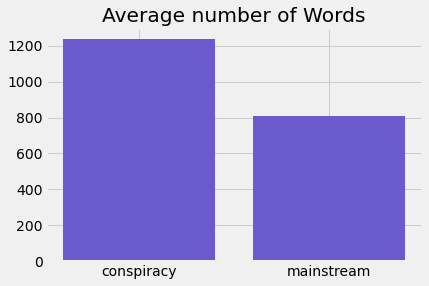

In [130]:
avg_words = LOCO_data.groupby(["subcorpus"])[["txt_nwords"]].mean().reset_index()
plt.bar(avg_words["subcorpus"], avg_words["txt_nwords"], color = "slateblue")
plt.title("Average number of Words")
plt.show()

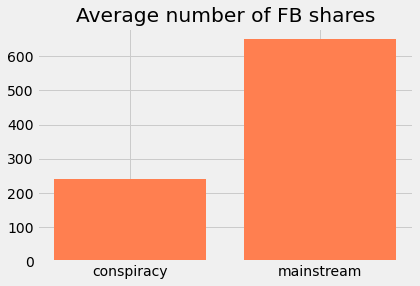

In [128]:
avg_shares = LOCO_data.groupby(["subcorpus"])[["FB_shares"]].mean().reset_index()
plt.bar(avg_shares["subcorpus"], avg_shares["FB_shares"], color = "coral")
plt.title("Average number of FB shares")
plt.show()

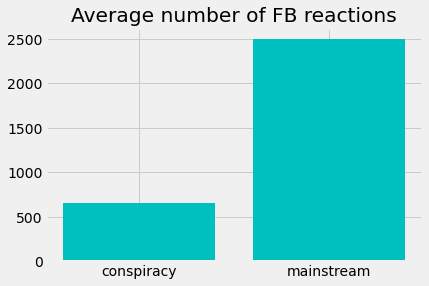

In [129]:
avg_reacts = LOCO_data.groupby(["subcorpus"])[["FB_reactions"]].mean().reset_index()
plt.bar(avg_reacts["subcorpus"], avg_reacts["FB_reactions"], color = "c")
plt.title("Average number of FB reactions")
plt.show()

## Start topic modeling

In [3]:
y = LOCO_data["response"]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(LOCO_data.drop("response", axis = "columns"), 
                                        y, test_size=0.2, random_state=0)

In [5]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,1))

In [6]:
X_tr_dtm = cv.fit_transform(X_train["tokens"])

In [7]:
X_test_dtm = cv.transform(X_test["tokens"])

In [8]:
nmf = NMF(20)
X_tr_nmf = nmf.fit_transform(X_tr_dtm)

/home/marcel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [9]:
topic_term = nmf.components_.round(3)

In [10]:
topic_term.shape

(20, 307246)

In [11]:
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [12]:
output = display_topics(nmf, cv.get_feature_names(), 10)

/home/marcel/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic  1
world, war, new, states, government, united, american, order, international, global

Topic  2
virus, zika, infection, infected, disease, cells, viruses, mosquito, transmission, cases

Topic  3
al, et, species, data, used, study, use, using, control, time

Topic  4
people, like, know, think, going, god, time, way, say, want

Topic  5
climate, change, global, warming, emissions, carbon, energy, scientists, earth, greenhouse

Topic  6
cancer, cells, cell, treatment, breast, patients, cancers, risk, tumor, lung

Topic  7
vaccine, vaccines, children, vaccination, autism, measles, flu, disease, mmr, influenza

Topic  8
hiv, aids, people, treatment, infection, infected, men, africa, virus, disease

Topic  9
said, told, people, year, according, officials, coronavirus, country, state, say

Topic  10
president, trump, bush, obama, house, clinton, campaign, american, white, state

Topic  11
health, public, care, national, people, medical, children, state, information, women

Topic  12
d

In [13]:
X_test_nmf = nmf.transform(X_test_dtm)

In [85]:
X_test_nmf = pd.DataFrame(X_test_nmf)
X_test_nmf.columns = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8",
                               "Topic 9","Topic 10","Topic 11","Topic 12","Topic 13","Topic 14","Topic 15","Topic 16",
                               "Topic 17","Topic 18","Topic 19","Topic 20",]
X_test_nmf = X_test_nmf.set_index(X_test.index)
X_test = pd.concat([X_test, X_test_nmf], axis = 1)

In [86]:
X_test

,doc_id,URL,website,seeds,date,subcorpus,title,txt_nwords,txt_nsentences,txt_nparagraphs,topic_k100,topic_k200,topic_k300,mention_conspiracy,conspiracy_representative,cosine_similarity,FB_shares,FB_comments,FB_reactions,tokens,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
7303,C02311,https://www.nowtheendbegins.com/heres-shouldnt...,nowtheendbegins.com,jfk.assassination,2017-10-27,conspiracy,Here's Why You Shouldn't Get Too Excited About...,1078,50,18,k100_30,k200_137,k300_100,2,0.0,0.1704,0.0,0.0,0.0,"['president', 'trump', 'delayed', 'thursday', ...",0.007253,0.000000,0.004497,0.045556,0.000000,0.006537,0.000000,0.000000,0.022307,0.148688,0.015586,0.003324,0.000000,0.079682,0.000000,0.002651,0.000000,0.004264,0.000000,0.144435
36865,M0bcc3,https://www.medicalnewstoday.com/articles/323880,medicalnewstoday.com,aids,NaT,mainstream,Does HIV increase cancer risk? Types and treat...,703,45,25,k100_12,k200_67,k300_297,0,NaN,NaN,1.0,0.0,1.0,"['also', 'discuss', 'people', 'hiv', 'lower', ...",0.000000,0.000000,0.000000,0.102848,0.000000,0.673480,0.000000,0.420296,0.000000,0.000000,0.001168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17114,C052b7,https://www.newstarget.com/2018-06-29-public-h...,newstarget.com,fluoride.water,2018-12-05,conspiracy,Public health fraud: Why water fluoridation is...,644,32,14,k100_40,k200_13,k300_2,1,0.0,0.0969,0.0,0.0,0.0,"['public', 'health', 'fraud', 'water', 'fluori...",0.000000,0.000000,0.000000,0.014938,0.000000,0.016555,0.032086,0.000000,0.000000,0.000000,0.066610,0.000000,0.000000,0.000000,0.000652,0.000000,0.000000,0.658364,0.025525,0.000000
72146,M183ce,https://www.businessinsider.com/jake-tapper-pi...,businessinsider.com,pizzagate,2016-12-05,mainstream,Michael Flynn’s son spars with Jake Tapper ove...,347,24,10,k100_9,k200_172,k300_192,4,NaN,NaN,17.0,12.0,29.0,"['retired', 'lt', 'gen', 'michael', 'flynn', '...",0.000000,0.000398,0.000000,0.007898,0.000000,0.000000,0.005307,0.000000,0.037976,0.023230,0.000000,0.000000,0.000000,0.018041,0.000000,0.000000,0.000000,0.000000,0.000000,0.060757
50090,M1076a,https://www.newyorker.com/news/our-columnists/...,newyorker.com,coronavirus; covid.19,2020-05-08,mainstream,Can the Middle East Recover from the Coronavir...,1260,50,9,k100_45,k200_47,k300_288,0,NaN,NaN,192.0,70.0,377.0,"['year', 'ago', 'iran', 'marked', 'national', ...",0.129870,0.000000,0.000000,0.024371,0.013605,0.000000,0.010475,0.005859,0.033058,0.052842,0.000000,0.000000,0.116141,0.037581,0.000000,0.001162,0.160114,0.009914,0.007468,0.038063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47315,M0f7d9,https://apnews.com/d6acf1f1d6c942df9825c5b080f...,apnews.com,new.world.order,2020-06-18,mainstream,Global Markets for Office and Commercial Coffe...,475,20,10,k100_14,k200_73,k300_6,0,NaN,NaN,0.0,0.0,0.0,"['office', 'commercial', 'coffee', 'equipment'...",0.071007,0.000000,0.015911,0.000000,0.038633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057157,0.015386,0.000000,0.004693,0.000000,0.108163,0.006435,0.000000,0.002906
83784,M1c5e6,https://hbr.org/2004/04/bringing-the-market-in...,hbr.org,george.bush,2004-04-01,mainstream,Bringing the Market Inside,289,11,3,k100_16,k200_83,k300_23,0,NaN,NaN,0.0,0.0,0.0,"['dot', 'com', 'boom', 'many', 'people', 'saw'...",0.008806,0.000000,0.021427,0.049306,0.023211,0.000000,0.000000,0.000000,0.000000,0.000000,0.003199,0.033911,0.023368,0.000000,0.001696,0.000000,0.000000,0.000000,0.000000,0.011661
27073,M085c6,https://www.who.int/gho/hiv/hiv_text/en/,who.int,aids,NaT,mainstream,Outlook,345,15,4,k100_82,k200_124,k300_244,0,NaN,NaN,0.0,0.0,0.0,"['past', 'couple', 'decades', 'hiv', 'response...",0.001705,0.000000,0.001919,0.022597,0.029565,0.000000,0.000000,0.317422,0.000000,0.000

In [87]:
X_tr_nmf = pd.DataFrame(X_tr_nmf)
X_tr_nmf.columns = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6","Topic 7","Topic 8",
                               "Topic 9","Topic 10","Topic 11","Topic 12","Topic 13","Topic 14","Topic 15","Topic 16",
                               "Topic 17","Topic 18","Topic 19","Topic 20",]
X_tr_nmf = X_tr_nmf.set_index(X_train.index)
X_train = pd.concat([X_train, X_tr_nmf], axis = 1)

In [88]:
X_train["response"] = y_train
X_train_model = X_train.drop(["date","doc_id", "URL", "website", "seeds", "subcorpus", "title", "topic_k100", "topic_k200",
                              "topic_k300", "mention_conspiracy", "conspiracy_representative","cosine_similarity", "tokens"], axis = 1)
X_train_model = X_train_model.dropna()
y_train = X_train_model["response"]
X_train_model = X_train_model.drop(["response"], axis = 1)

In [89]:
X_test["response"] = y_test
X_test_model = X_test.drop(["date","doc_id", "URL", "website", "seeds", "subcorpus", "title", "topic_k100", "topic_k200",
                              "topic_k300", "mention_conspiracy", "conspiracy_representative","cosine_similarity", "tokens"], axis = 1)
X_test_model = X_test_model.dropna()
y_test = X_test_model["response"]
X_test_model = X_test_model.drop(["response"], axis = 1)

In [90]:
X_test_model

,txt_nwords,txt_nsentences,txt_nparagraphs,FB_shares,FB_comments,FB_reactions,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
7303,1078,50,18,0.0,0.0,0.0,0.007253,0.000000,0.004497,0.045556,0.000000,0.006537,0.000000,0.000000,0.022307,0.148688,0.015586,0.003324,0.000000,0.079682,0.000000,0.002651,0.000000,0.004264,0.000000,0.144435
36865,703,45,25,1.0,0.0,1.0,0.000000,0.000000,0.000000,0.102848,0.000000,0.673480,0.000000,0.420296,0.000000,0.000000,0.001168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17114,644,32,14,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.014938,0.000000,0.016555,0.032086,0.000000,0.000000,0.000000,0.066610,0.000000,0.000000,0.000000,0.000652,0.000000,0.000000,0.658364,0.025525,0.000000
72146,347,24,10,17.0,12.0,29.0,0.000000,0.000398,0.000000,0.007898,0.000000,0.000000,0.005307,0.000000,0.037976,0.023230,0.000000,0.000000,0.000000,0.018041,0.000000,0.000000,0.000000,0.000000,0.000000,0.060757
50090,1260,50,9,192.0,70.0,377.0,0.129870,0.000000,0.000000,0.024371,0.013605,0.000000,0.010475,0.005859,0.033058,0.052842,0.000000,0.000000,0.116141,0.037581,0.000000,0.001162,0.160114,0.009914,0.007468,0.038063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47315,475,20,10,0.0,0.0,0.0,0.071007,0.000000,0.015911,0.000000,0.038633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057157,0.015386,0.000000,0.004693,0.000000,0.108163,0.006435,0.000000,0.002906
83784,289,11,3,0.0,0.0,0.0,0.008806,0.000000,0.021427,0.049306,0.023211,0.000000,0.000000,0.000000,0.000000,0.000000,0.003199,0.033911,0.023368,0.000000,0.001696,0.000000,0.000000,0.000000,0.000000,0.011661
27073,345,15,4,0.0,0.0,0.0,0.001705,0.000000,0.001919,0.022597,0.029565,0.000000,0.000000,0.317422,0.000000,0.000000,0.103696,0.000000,0.007563,0.000000,0.000000,0.001168,0.006786,0.000000,0.000000,0.000000
14092,4168,230,41,0.0,0.0,0.0,0.000000,0.041018,0.136999,0.392559,0.000000,0.098508,0.000000,0.003349,0.060910,0.000000,0.000000,0.319669,0.000000,0.000000,0.132256,0.034694,0.023727,0.180811,0.053096,0.309322


In [91]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_model, y_train)

LogisticRegression(max_iter=1000)

In [92]:
pred = lr.predict(X_test_model)

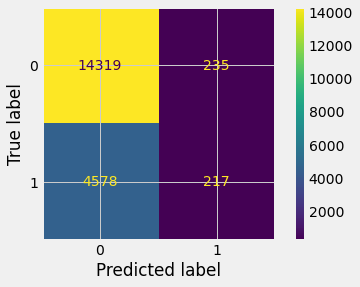

In [93]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=lr.classes_)
disp.plot()
plt.show()

In [94]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=3, n_estimators = 100)
rfc.fit(X_train_model, y_train)

RandomForestClassifier(max_depth=3)

In [95]:
pred = rfc.predict(X_test_model)

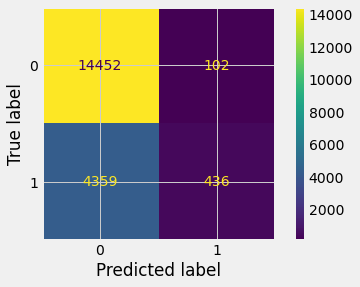

In [96]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=rfc.classes_)
disp.plot()
plt.show()

In [97]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))
print("Precision: {}".format(metrics.precision_score(y_test, pred)))
print("Recall: {}".format(metrics.recall_score(y_test, pred)))
print("F1: {}".format(metrics.f1_score(y_test, pred)))

Accuracy: 0.7694454493772288
Precision: 0.8104089219330854
Recall: 0.09092805005213764
F1: 0.1635102193887118


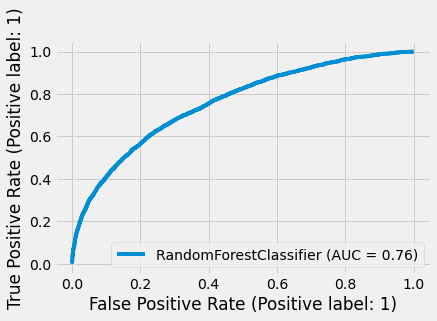

In [98]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc, X_test_model, y_test)
plt.show()

<BarContainer object of 26 artists>

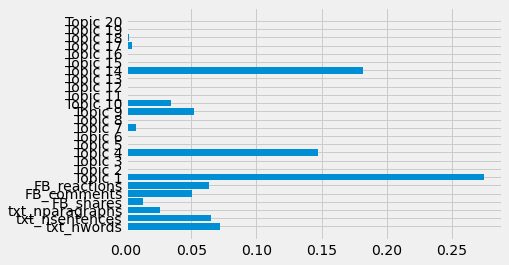

In [99]:
plt.barh(rfc.feature_names_in_,rfc.feature_importances_)